# **Bias measuring and mitigation in recommendation systems**

The bias problem can appear in models when the predictions systematically deviate from the true values for certain subgroups in the dataset. This phenomenon can occur due to various reasons such as unbalanced groups in the training data, feature selection, or model specification. Because of this, the bias problem can appear in different tasks, being "recommendation systems" one of them. A recommender system aims to recommend the best item according to the user preference.

There are various techniques to measure bias in recommendation systems. One common approach is to use fairness metrics such as aggregate diversity, exposure entropy, or gini index, which are item based metrics that, in general terms, calculate the distribution to observe the proportions of items are shown to the user.

Once bias is detected, we can employ different techniques to mitigate it. These methods can be grouped into three categories: Pre-processing, in-processing and post-processing methods. Pre-processing techniques are used to adjust the training data to remove bias, while in-processing methods are applied to build robust models against bias. Finally, post-processing techniques are used to adjust the model's predictions to remove bias.

A recommender system can be biased in multiple ways. For example, we may be concerned that the artists in our database will not get equal representation (item fairness). Alternative, our main concern may be that different groups of users (e.g. male/female users) will get different music recommendations (user fairness). In the following, we will show how to explore the data for fairness, and measure these various types of fairness using the holisticai library.

Through this tutorial, we pretend to present you tools which can be easily applied to measure and mitigate the presence of bias in recommender systems, by using a synthetic dataset that generates rankings of candidates using the Yang-Stoyanovich process.

We will follow the traditional outline for this tutorial:

1. Data loading and packages installation
2. Data exploration
3. Bias measuring
4. Bias mitigation
5. Results comparison

## **1. Data tasks: loading, exploration and preprocessing**

First of all, we need to import the required packages to perform our bias analysis and mitigation. You will need to have the `holisticai` package installed on your system, remember that you can install it by running: 
```bash
!pip install holisticai
```

In [1]:
# Base Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

The dataset that we will use is a synthetic ranking dataset generated following the procedure described by Yang and Stoyanovich in their [research](https://arxiv.org/abs/1610.08559). This algorithm creates a ranked output of protected and unprotected candidates with a certain probability.

To do that we will use the `generate_rankings` function that takes as arguments the number of `k` elements that will be generated for all the `M` lists under a probability `p` to be protected. 

For our case we will generate only one ranked list of 20 elements.

In [2]:
from holisticai.datasets.synthetic.recruitment import generate_rankings

In [4]:
M = 1
k = 20
p = 0.1
ranking = generate_rankings(M, k, p)
ranking.head()

,X,Y,score,protected
0,0,20,20,False
1,0,19,19,True
2,0,18,18,False
3,0,17,17,False
4,0,16,16,False


To add bias into the dataset we will modify the `protected` column where the protected elements will be only the last six elements.

In [5]:
def create_unfair_example(ranking, n):
    """
    Setting an unfair ranking where protected group examples are only the last n results.
    """
    ranking = ranking.copy()
    ranking['protected']=False
    ranking['protected'].iloc[-n:]=True
    return ranking
    
unfair_ranking = create_unfair_example(ranking, 6)

In [6]:
unfair_ranking

,X,Y,score,protected
0,0,20,20,False
1,0,19,19,False
2,0,18,18,False
3,0,17,17,False
4,0,16,16,False
5,0,15,15,False
6,0,14,14,False
7,0,13,13,False
8,0,12,12,False
9,0,11,11,False



We now will create a new synthetic dataset to fit the mitigator which then will be used for the unfair dataset created previously.

From now on, we are going to assume that both rankings are outputs from a recommender system, and we will analyze the bias in the recommendations. Therefore, our purpose will be to measure and then  mitigate the bias in the recommendations.

In [7]:
# Synthetic data
M = 1000
top_n = 20
p = 0.25
rankings = generate_rankings(M, top_n, p, return_p_attr=False)

## **2. Data exploration**

In [8]:
unfair_ranking.describe()

,X,Y,score
count,20.0,20.00000,20.00000
mean,0.0,10.50000,10.50000
std,0.0,5.91608,5.91608
min,0.0,1.00000,1.00000
25%,0.0,5.75000,5.75000
50%,0.0,10.50000,10.50000
75%,0.0,15.25000,15.25000
max,0.0,20.00000,20.00000


In [9]:
rankings.describe()

,X,Y,score
count,20000.000000,20000.000000,20000.000000
mean,499.500000,10.500000,10.500000
std,288.682207,5.766425,5.766425
min,0.000000,1.000000,1.000000
25%,249.750000,5.750000,5.750000
50%,499.500000,10.500000,10.500000
75%,749.250000,15.250000,15.250000
max,999.000000,20.000000,20.000000


<Axes: title={'center': 'Group proportions'}>

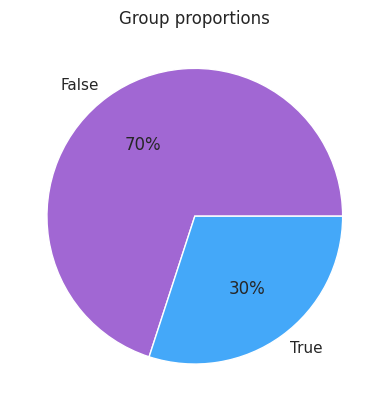

In [10]:
from holisticai.plots.bias import group_pie_plot, frequency_plot

group_pie_plot(unfair_ranking['protected'])

This graph show us that the proportion of the unprotected group is very high compared to the protected examples for the unfair dataset.


<Axes: title={'center': 'Group proportions'}>

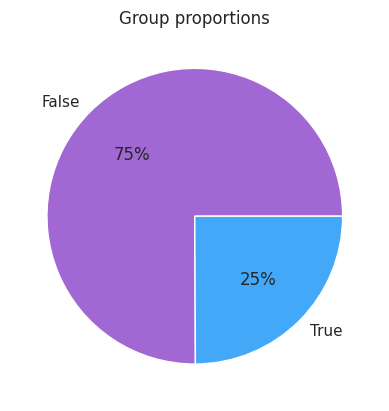

In [11]:
group_pie_plot(rankings['protected'])

A similar proportion is observed for the syntetic dataset, where the protected examples are only the 25% of the total data.

## **3. Bias measuring**

For these dataset we do not need to perform any preprocessing step, so we can use them directly to calculate the various metrics of fairness for recommender systems. In this example, we will use the `exposure_metric` function that calculates the exposure ratio and difference from the actual rankings for both datasets.


In [12]:
from holisticai.mitigation.bias.postprocessing.debiasing_exposure.algorithm_utils import exposure_metric

In [13]:
baseline = exposure_metric(rankings, group_col='protected', query_col='X', score_col='score')
baseline

,Value
exposure_ratio,33221.217929
exposure difference,0.048336


In [14]:
baseline_unfair = exposure_metric(unfair_ranking, group_col='protected', query_col='X', score_col='score')
baseline_unfair

,Value
exposure_ratio,516682.109793
exposure difference,0.103049


Above we have batch plotted some exposure based metrics for both datasets. For example:

*   **Exposure ratio:** Calculates the relation between the exposure of non-protected and protected elements from the dataset. For a fairer model we seek to have this value lower, indicating that the protected examples are gaining more exposure.
*   **Exposure difference:** Calculates the difference of exposure between the two groups this value will be zero when the protected group achieves more exposure than the non-protected.

## **4. Bias mitigation**

### **Post-processing: Debiasing Exposure method**

Now that we could observe that the metrics are far away from the desired values, we need to apply some kind of strategy to mitigate the bias present.

Exists different kinds of strategies, and the literature has divided them into three categories: "Pre-processing", "in-processing" and "post-processing" methods. The `holisticai` library possesses different algorithms from these categories for bias mitigation. An interesting feature is that all of them are compatible with the `Scikit-learn` package, so that, if you are familiar with this package, you will not have problems using the library.

For this opportunity, we will implement the "Debiasing exposure" method which is a postprocessing algorithm that incorporates a measure of performance and a measure of disparate exposure into its loss function training a linear model based on performance and fairness for a protected group.

In [15]:
from holisticai.mitigation.bias.postprocessing import DebiasingExposure

In [16]:
# create the DebiasingExposure class
dtr = DebiasingExposure(group_col="protected",
                        query_col = 'X',
                        doc_col = 'Y',
                        feature_cols = ['score', 'protected'],
                        score_col = 'score',
                        gamma=2, 
                        number_of_iterations=100, 
                        standardize=True,
                        verbose=1)

# train the model
dtr.fit(rankings)

100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


## **5. Results comparison**
Now that we could observe how is the implementation of the mitigator, we will compare the results between the baseline and the implementations with the mitigator to analyse how the metrics have changed.

In [17]:
re_rankings = dtr.transform(rankings)

In [18]:
df_deb_exp = exposure_metric(re_rankings, group_col='protected', query_col='X', score_col='score')
df_deb_exp

,Value
exposure_ratio,0.766309
exposure difference,0.002585


In [19]:
re_ranking = dtr.transform(unfair_ranking)

In [20]:
df_deb_exp_unfair = exposure_metric(re_ranking, group_col='protected', query_col='X', score_col='score')
df_deb_exp_unfair

,Value
exposure_ratio,2.244740
exposure difference,0.047982


In [21]:
result = pd.concat([baseline, df_deb_exp], axis=1).iloc[:, [0,1]]
result.columns = ['Baseline','Mitigator']
result

,Baseline,Mitigator
exposure_ratio,33221.217929,0.766309
exposure difference,0.048336,0.002585


In [22]:
result = pd.concat([baseline_unfair, df_deb_exp_unfair], axis=1).iloc[:, [0,1]]
result.columns = ['Baseline','Mitigator']
result

,Baseline,Mitigator
exposure_ratio,516682.109793,2.244740
exposure difference,0.103049,0.047982


From the previous chart, we can see that certainly, an improvement is obtained by applying this method in the data, compared with our initial calculations for both datasets. 

Notice that we can analyse how these values are affected by varying the hyperparameters of the method.

For example, this method allows us to set the `gamma` parameter for the cost calculation, the number of iterations, the learning rate and a regularization constant `lambdaa` for each individual test.

Let's try with different values of `gamma`:

In [23]:
def calculate_metrics(ranking, unfair_rnk, gamma, metrics_cols):

  dtr = DebiasingExposure(group_col="protected",
                        query_col = 'X',
                        doc_col = 'Y',
                        feature_cols = ['score', 'protected'],
                        score_col = 'score',
                        gamma=gamma,
                        number_of_iterations=100, 
                        standardize=True,
                        verbose=1)
  dtr.fit(ranking)
  ranking_ = dtr.transform(unfair_rnk)

  df = exposure_metric(ranking_, group_col='protected', query_col='X', score_col='score')

  # Calculate metrics
  metrics = [
      gamma,
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics

In [24]:
metrics_val = []
metrics_cols = ["exposure_ratio", "exposure difference"]

for gamma in np.linspace(0.2,2,5):
  metrics_val.append(calculate_metrics(rankings, unfair_ranking, gamma, metrics_cols))

metrics = ['gamma']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


,gamma,exposure_ratio,exposure difference
0,0.20,6.726198,0.082474
1,0.65,3.267800,0.063223
2,1.10,2.692175,0.055877
3,1.55,2.415659,0.051291
4,2.00,2.244758,0.047982


Text(0.5, 0, 'Gamma')

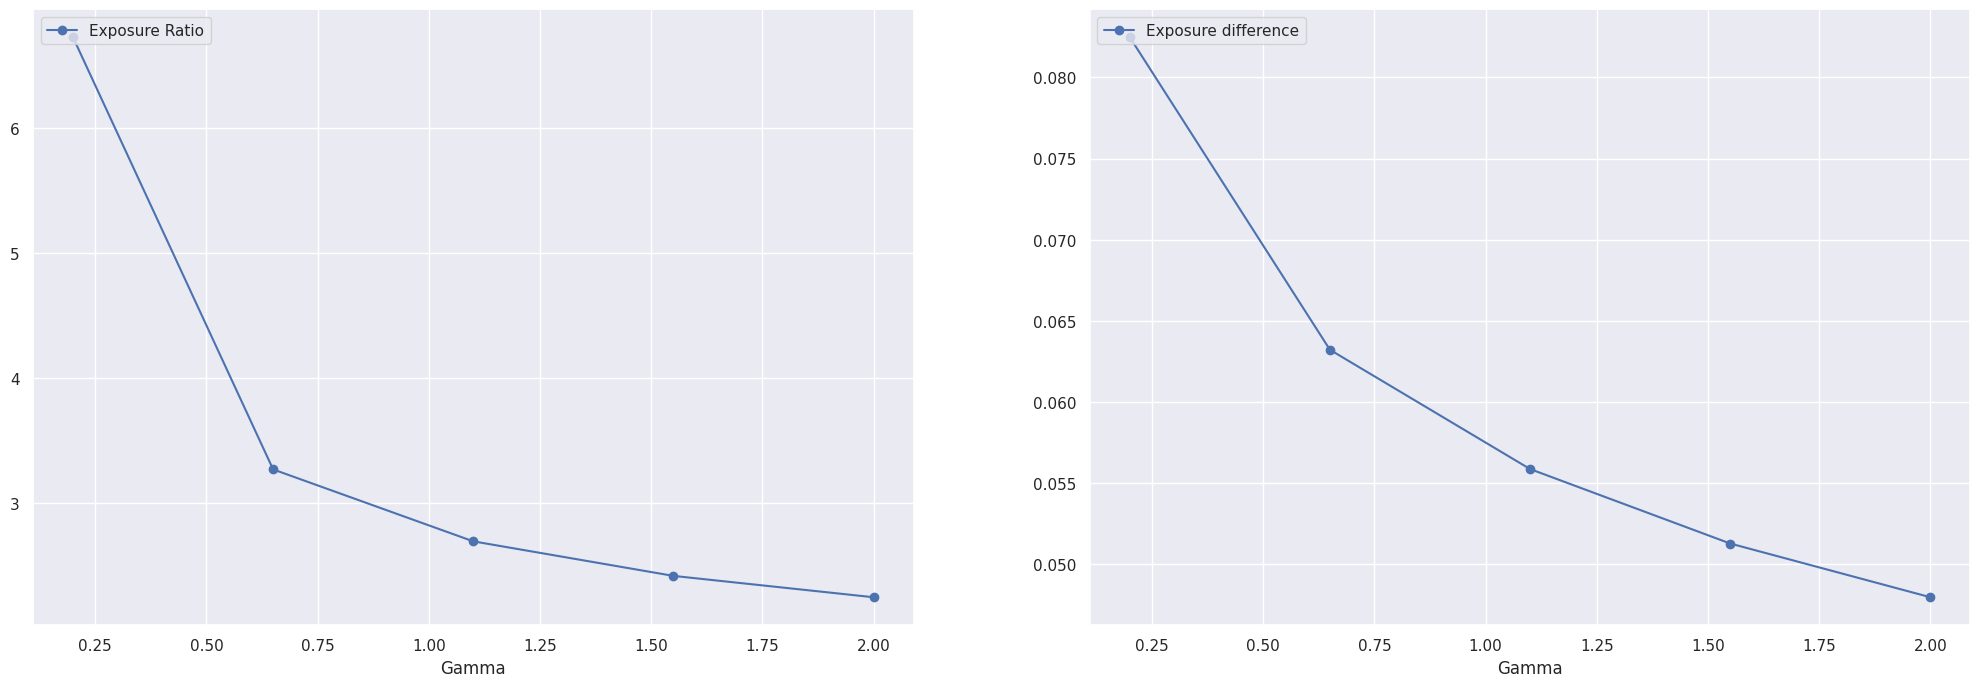

In [25]:
x_axis = df_metrics.gamma
plt.figure(figsize=(25,8))
plt.subplot(121)
plt.plot(x_axis, df_metrics['exposure_ratio'], 'o-', label='Exposure Ratio')
plt.legend(loc='upper left')
plt.xlabel('Gamma')
plt.subplot(122)
plt.plot(x_axis, df_metrics['exposure difference'], 'o-', label='Exposure difference')
plt.legend(loc='upper left')
plt.xlabel('Gamma')

As we can see, the selection of different values for this parameter will vary its performance, for example, we can observe that in general terms we achieve a better model when the value of `gamma` is increased.

# **Summary**

Through this tutorial we could present to the user how the `holisticai` library can be easily used to measure the bias present in recommender systems by the application of the `exposure_metric` function, which returns the calculated values for different metrics respectively.

In addition, we shown how to mitigate the bias by applying some methods, for this opportunity we applied the "Debiasing exposure" technique to train a fairness model, this is a post-processing method that incorporates performance  and exposure metrics into its loss function to obtain fairness for a protected group. Consequently we could observe how the metrics are influenced by varing the `gamma` parameter, and showing that this method increases the fairness of the model.